In [1]:
from __future__ import division

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
# normalize
X = StandardScaler().fit_transform(X)

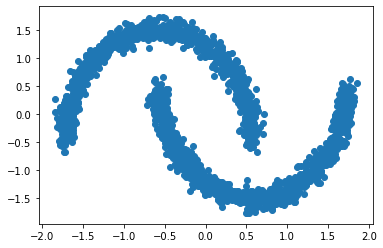

In [3]:
plt.scatter(X[:, 0], X[:, 1])

# R-NVP

In [4]:
import torch
import torch.nn as nn 
from math import pi 

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal

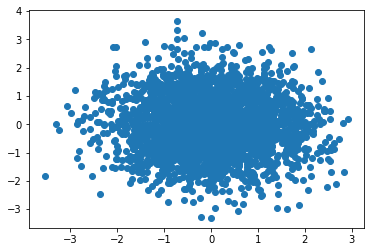

In [5]:
base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_dist = MultivariateNormal(base_mu, base_cov)
Z = base_dist.rsample(sample_shape=(3000,))
plt.scatter(Z[:, 0], Z[:, 1])
plt.show()

In [6]:
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [7]:
class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z

## Training/Viewing BoilerPlate Code

In [8]:
def train(model, epochs, batch_size, optim, scheduler):
    losses = []
    for _ in range(epochs):

        # get batch 
        X, _ = datasets.make_moons(n_samples=batch_size, noise=.05)
        X = torch.from_numpy(StandardScaler().fit_transform(X)).float()

        optim.zero_grad()
        z, log_pz, log_jacob = model(X)
        loss = (-log_pz - log_jacob).mean()
        losses.append(loss)

        loss.backward()
        optim.step()
        scheduler.step()
    return losses

In [9]:
def view(model, losses):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    X_hat = model.inverse(Z).detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1])
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.show()

    n_samples = 3000
    X, _ = datasets.make_moons(n_samples=n_samples, noise=.05)
    X = torch.from_numpy(StandardScaler().fit_transform(X)).float()
    z, _, _ = model(X)
    z = z.detach().numpy()
    plt.scatter(z[:, 0], z[:, 1])
    plt.title("Transformation of Data Samples X: Z = F(X)")
    plt.show()

## Model Params

In [10]:
d = 2
k = 1

# Single Layer R_NVP

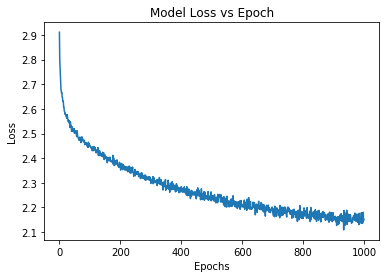

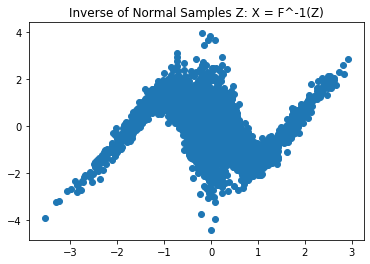

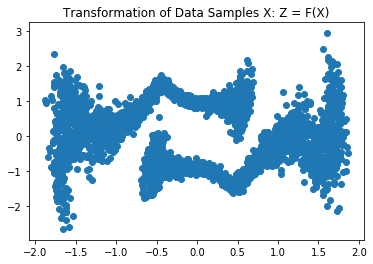

In [11]:
model = R_NVP(d, k, hidden=512)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)

# 3 Layer R_NVP

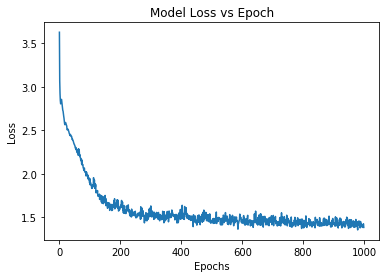

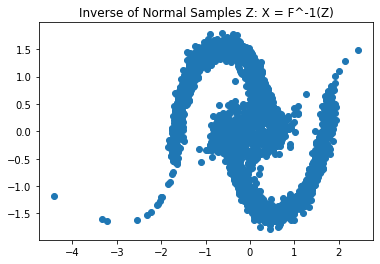

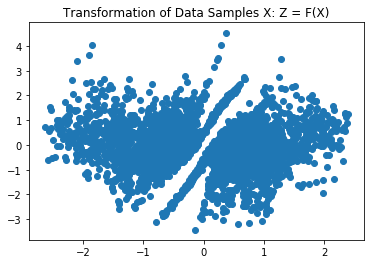

In [18]:
model = stacked_NVP(d, k, hidden=512, n=3)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)

# 5 Layer R_NVP

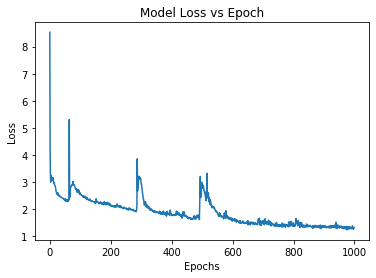

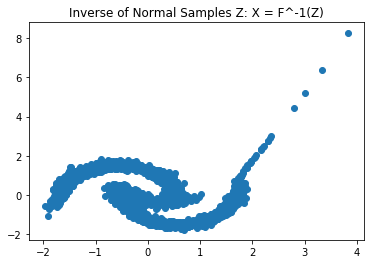

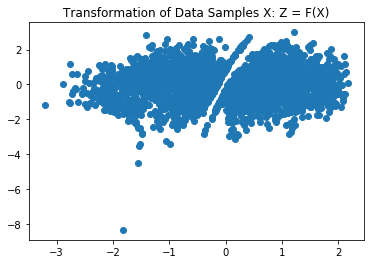

In [17]:
model = stacked_NVP(d, k, hidden=512, n=5)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)

n_samples = 512

# training loop
losses = train(model, 1000, n_samples, optim, scheduler)
view(model, losses)